In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

1、数据集中的变量较多，如果全部进入模型会导致模型解释困难。因此，一方面我们对于有相关性的变量进行降维，减少变量数目；另一方面，基于业务理解，我们预先将变量进行分组，使得同一组的变量能尽量解释业务的一个方面。比如本例中将变量分成两组，分别是家庭基本情况和用户爱好，通过对每组变量分别进行聚类，获取用户的侧写，再将两个聚类结果进行综合，以获得较完整的用户画像。

2、本例中数据类型复杂，包含了连续变量、无序分类和有序分类变量。由于K-means仅用于连续型变量聚类，因此需要对变量进行预处理。对于有序分类变量，如果分类水平较多可以视作连续变量处理，否则视作无序分类变量一样处理，再进入模型；无序分类变量数目较少时，可以使用其哑变量编码进入模型。本例中由于有较多的二分类变量，又集中在用户爱好这一方面，因此我们将interested_reading这一有序分类变量二值化，再与其他几个二分类变量一起进行汇总，得到用户的“爱好广度”，使用“爱好广度”与其他连续型的爱好类变量进行聚类。

3、离散变量如HH_has_children一般不参与聚类，因为其本身就可以视作是簇的标签；如果为了后期解释模型时简化处理，在离散变量不多的情况之下，也可以做哑变量变换后进入模型。

In [2]:
data_travel = pd.read_csv('C:/Users/acerpc/Desktop/data_folder/data_travel.csv')
data_travel.head()

,interested_travel,computer_owner,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,interested_golf,interested_gambling,HH_has_children,HH_adults_num,interested_reading
0,NaN,NaN,64,124035,73,932,3,312,420,149,96,626,0,0,NaN,NaN,0
1,0.0,1.0,69,138574,73,1000,7,241,711,263,68,658,0,0,N,5.0,3
2,0.0,0.0,57,148136,77,688,1,367,240,240,56,354,0,1,N,2.0,1
3,1.0,1.0,80,162532,74,932,7,291,832,197,86,462,1,1,Y,2.0,3
4,1.0,1.0,48,133580,77,987,10,137,121,209,42,423,0,1,Y,3.0,3


In [3]:
data_travel.describe(include='all')

,interested_travel,computer_owner,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,interested_golf,interested_gambling,HH_has_children,HH_adults_num,interested_reading
count,149788.000000,149788.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,159899,145906.000000,167177
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,3
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111462,NaN,65096
mean,0.427745,0.856571,59.507079,207621.314798,66.762707,817.031751,6.884015,259.431776,377.072498,204.593341,59.368023,486.861273,0.373012,0.357842,NaN,2.770832,NaN
std,0.494753,0.350511,14.311733,107822.501900,9.751835,165.490295,2.610552,78.867456,248.045395,78.971038,16.712912,151.167457,0.483607,0.479367,NaN,1.285417,NaN
min,0.000000,0.000000,18.000000,48910.000000,0.000000,1.000000,1.000000,60.000000,0.000000,47.000000,18.000000,49.000000,0.000000,0.000000,NaN,0.000000,NaN
25%,0.000000,1.000000,49.000000,135595.000000,63.000000,748.000000,5.000000,204.000000,182.000000,144.000000,48.000000,377.000000,0.000000,0.000000,NaN,2.000000,NaN
50%,0.000000,1.000000,59.000000,182106.000000,69.000000,844.000000,7.000000,251.000000,351.000000,185.000000,60.000000,492.000000,0.000000,0.000000,NaN,2.000000,NaN
75%,1.000000,1.000000,70.000000,248277.000000,73.000000,945.000000,9.000000,306.000000,528.000000,252.000000,71.000000,600.000000,1.000000,1.000000,NaN,4.000000,NaN


# 数据预处理

填补缺失值(有缺失情况的变量皆为分类变量，且确实比例并不高，因此用众数进行填补)

In [4]:
fill_col = []
fill = {}
for col in data_travel.columns:
    if data_travel[col].count()!=len(data_travel):
        fill_col.append(col)
        fill[col] = data_travel[col].mode()[0]
travel = data_travel.fillna(fill)

修正错误值

HH_has_children的分类水平以字符形式表示，需要转换为整型，同时其中的缺失值应当表示没有小孩，因此替换为0 阅读爱好interested_reading中包含错误值“.”，将其以0进行替换，代表该用户对阅读没有兴趣。

In [5]:
travel['interested_reading'].value_counts()

3    65096
1    43832
0    32919
2    24488
.      842
Name: interested_reading, dtype: int64

In [6]:
travel['HH_has_children'] = travel['HH_has_children'].replace({'N':0,'Y':1})
travel['interested_reading'] = travel['interested_reading'].replace({'.':'0'}).astype('int')

对离散型变量进行处理

使用k-means聚类，一般不分析离散变量，但可以根据业务理解，将离散型变量进行变换

分析离散变量的相关性

In [7]:
unique = {}
for col in travel.columns:
    unique[col] = len(travel[col].value_counts())
unique = pd.DataFrame(unique,index=[0,])
cols = [col for col in unique if unique[col][0]<=10]

In [8]:
sample = travel[cols].sample(3000,random_state=1234)
cols

['interested_travel',
 'computer_owner',
 'marital',
 'interested_golf',
 'interested_gambling',
 'HH_has_children',
 'HH_adults_num',
 'interested_reading']

In [9]:
from itertools import combinations
from scipy import stats

for col1,col2 in combinations(cols,2):#选取两两值
    cross_tab = pd.crosstab(sample[col1],sample[col2])
    p = stats.chi2_contingency(cross_tab)[1]
    if p>0.05:
        print('p-value = %0.3f between "%s" and "%s"'%(p,col1,col2))

p-value = 0.785 between "computer_owner" and "HH_has_children"
p-value = 0.080 between "interested_golf" and "HH_has_children"
p-value = 0.392 between "interested_gambling" and "HH_has_children"


对于用户爱好，可以将旅行、电脑、高尔夫、博彩、阅读这几个分类型变量综合成一个爱好广度指标，其代表了用户休闲娱乐爱好，而连续型的interested_sport、HH_dieting属于健康类爱好，auto_member属于奢侈型爱好，因此，可以从多个角度来分析用户的爱好。



先对interested_reading进行二值化

In [10]:
from sklearn.preprocessing import Binarizer

binar = Binarizer(threshold=1.7)
travel['interested_reading'] = binar.fit_transform(travel[['interested_reading']])

生成二分类偏好填充率

In [11]:
interest =[
    'interested_travel',
    'computer_owner',
    'interested_golf', 
    'interested_gambling',
    'interested_reading'
]

n = len(interest)
travel = travel.drop(interest,axis=1).assign(interest = travel[interest].sum(axis=1)/n)
travel.head()

,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,HH_has_children,HH_adults_num,interest
0,64,124035,73,932,3,312,420,149,96,626,0,2.0,0.2
1,69,138574,73,1000,7,241,711,263,68,658,0,5.0,0.4
2,57,148136,77,688,1,367,240,240,56,354,0,2.0,0.2
3,80,162532,74,932,7,291,832,197,86,462,1,2.0,1.0
4,48,133580,77,987,10,137,121,209,42,423,1,3.0,0.8


正态化、标准化

对不同类型变量执行不同处理，连续变量、有序分类变量及无序分类变量在处理上均有不同，因此先按类型对变量分组，不同组采用不同的处理策略

如果一个连续变量的可能取值很少，如marital（10个水平）、interest（5个水平）、HH_adults_num（8个水平）等，当将其作为普通连续变量一样进行分布转换，可能生成一些离群值（例如对marital使用scikit-learn进行正态转换，会发现1和10对应的数据点离开均值达到5个标准差）。因此本例中将这几个连续变量作为有序分类变量对待，但不进行分布转化，仅做标准化处理。

In [12]:
columns = travel.columns
for col in cols:
    if col in travel.columns:
        columns = columns.drop(col)
columns = columns.drop('interest')

categorical_cols = ['marital', 'interest', 'HH_adults_num']

discreate_cols = ['HH_has_children']

为了聚类后的簇大小能比较接近，对于偏态严重的连续变量应转换其分布，令其接近正态分布或均匀分布

对连续变量正态化

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002505C512B38>,
      dtype=object)

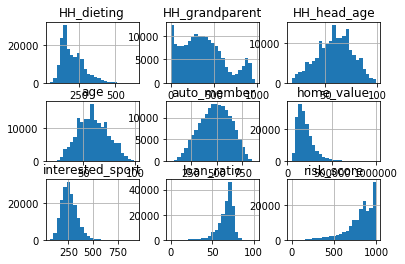

In [13]:
travel[columns].hist(bins=25)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002505BAF31D0>,
      dtype=object)

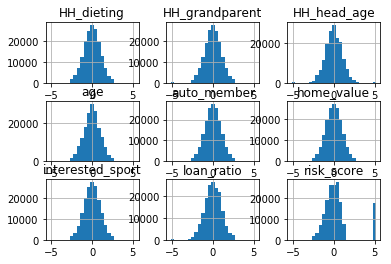

In [14]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal',n_quantiles=100)
qt_data = qt.fit_transform(travel[columns])
pd.DataFrame(qt_data,columns=columns).hist(bins=25)

对有多个水平的有序分类变量进行标准化

如前所述，尽管HH_adults_num、marital和interest属于连续变量，但都仅有不到10个水平，因此与有序分类变量一样，仅做标准化

In [15]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale_data = scale.fit_transform(travel[categorical_cols])

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


对二分类变量不做处理，合并各类型的变量

In [16]:
data = np.hstack([qt_data,scale_data,travel[discreate_cols]])
data = pd.DataFrame(data,columns=list(columns)+categorical_cols+discreate_cols)
data.head()

,age,home_value,loan_ratio,risk_score,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,marital,interest,HH_adults_num,HH_has_children
0,0.321971,-0.886981,0.698526,0.574460,0.731217,0.257832,-0.515705,2.572352,0.848859,-1.487818,-1.035281,-0.547836,0.0
1,0.619855,-0.621409,0.698526,5.199338,-0.152506,1.178235,0.822532,0.458679,1.073988,0.044429,-0.354828,1.895118,0.0
2,-0.126937,-0.464721,1.549706,-0.935569,1.314874,-0.446657,0.525369,-0.229884,-0.810751,-2.253942,-1.035281,-0.547836,0.0
3,1.335178,-0.253552,0.927754,0.574460,0.496519,1.407189,0.114185,1.639976,-0.175603,0.044429,1.686529,-0.547836,1.0
4,-0.747859,-0.706218,1.549706,1.144237,-1.816693,-0.934263,0.225553,-0.987837,-0.403108,1.193615,1.006077,0.266482,1.0


# 维度分析

根据业务需求，将变量从两个大的维度进行考虑

其一为用户家庭属性（包括家庭基本情况及财务情况），其二为用户个人偏好情况（包括对运动、节食等的兴趣程度）

In [17]:
household = ['age', 'marital', 'HH_adults_num', 'home_value', 
             'risk_score', 'HH_grandparent', 'HH_head_age', 'loan_ratio']
hobby = ['HH_dieting', 'auto_member','interest', 'interested_sport']
#  'HH_has_children'

In [18]:
data[hobby].corr()

,HH_dieting,auto_member,interest,interested_sport
HH_dieting,1.000000,0.134494,0.246663,0.510763
auto_member,0.134494,1.000000,0.316930,0.458942
interest,0.246663,0.316930,1.000000,0.219932
interested_sport,0.510763,0.458942,0.219932,1.000000


分别对两个维度进行因子分析，由于scikit-learn中的因子分析并不提供因子旋转，因此我们使用另外的因子分析包，例如fa-kit

先使用主成分分析确定保留多少个主成分合适：

In [19]:
from sklearn.decomposition import PCA

pca = PCA()
pca_data = pca.fit(data[household])
pca_data.explained_variance_ratio_.cumsum()

array([0.3527503 , 0.5647514 , 0.73013614, 0.82974587, 0.88389045,
       0.928455  , 0.96637073, 1.        ])

保留4个主成分是适当的

In [20]:
from fa_kit import FactorAnalysis
from fa_kit import plotting as fa_plotting

fa = FactorAnalysis.load_data_samples(data[household],preproc_demean=True, preproc_scale=True)
fa.extract_components()

D:\Anaconda3\lib\site-packages\fa_kit\factor_analysis.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  np_data = df_data.as_matrix()


设定提取主成分的方式。默认为“broken_stick”方法，建议使用“top_n”法

In [21]:
fa.find_comps_to_retain(method='top_n',num_keep=4)

array([0, 1, 2, 3], dtype=int64)

通过最大方差法进行因子旋转

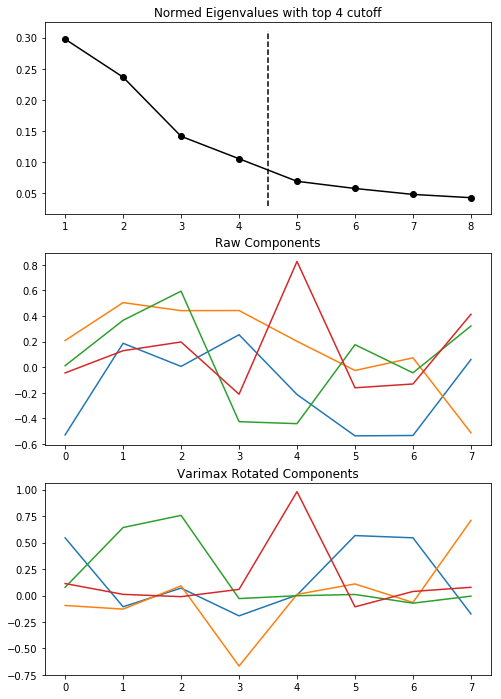

In [22]:
fa.rotate_components(method='varimax')
fa_plotting.graph_summary(fa);

各个因子：

In [23]:
pd.DataFrame(fa.comps['rot'].T,columns=household)

,age,marital,HH_adults_num,home_value,risk_score,HH_grandparent,HH_head_age,loan_ratio
0,0.545326,-0.106354,0.070273,-0.192308,0.004533,0.566902,0.545740,-0.173658
1,-0.094070,-0.128508,0.091275,-0.667143,0.011015,0.109534,-0.065677,0.710488
2,0.077588,0.642952,0.757906,-0.028831,-0.001865,0.009863,-0.072133,-0.006033
3,0.113537,0.010966,-0.010634,0.058182,0.982095,-0.107020,0.038337,0.077831


可以看到：

第一个因子在age、HH_grandparent、HH_head_age上的权重显著较高，从业务上理解，这三个变量的综合可以认为是用户所处的生命周期；
第二个因子在home_value、loan_ratio上的权重显著较高，这个因子主要表示了用户财务状况；
第三个因子在marital、HH_adults_num上的权重显著较高，该因子代表了家庭的人口规模；
第四个因子仅在risk_score上的权重较高，因此该因子代表的就是用户的风险

计算因子得分：

In [24]:
data_hh = pd.DataFrame(fa.get_component_scores(np.array(data[household])),
                       columns=['life_circle','finance', 'HH_size', 'risk'])
data_hh.head()

,life_circle,finance,HH_size,risk
0,1.853673,1.074320,-1.502466,0.208987
1,1.381082,1.156301,1.501759,2.553204
2,-0.418750,1.634256,-1.856860,-0.599059
3,2.231851,0.705320,-0.381568,0.240841
4,-1.689618,1.493770,0.981561,0.483107


In [25]:
pd.DataFrame(
    np.dot(data[household], fa.comps['rot']), 
    columns=['life_circle','finance', 'HH_size', 'risk']).head()

,life_circle,finance,HH_size,risk
0,1.897190,1.064567,-1.509544,0.664025
1,1.406500,1.176025,1.495519,5.066655
2,-0.430662,1.618538,-1.856263,-0.819556
3,2.267875,0.699754,-0.386823,0.691810
4,-1.712905,1.488629,0.982299,1.190735


同理，对用户的偏好属性进行因子分析：

In [26]:
hobby_data = pca.fit(data[hobby])
hobby_data.explained_variance_ratio_.cumsum()#保留三个因子

array([0.48934516, 0.71596975, 0.91157358, 1.        ])

In [27]:
fa_hob = FactorAnalysis.load_data_samples(data[hobby],preproc_demean=True, preproc_scale=True)
fa_hob.extract_components()

fa_hob.find_comps_to_retain(method='top_n',num_keep=3)
fa_hob.rotate_components(method='varimax')
pd.DataFrame(fa_hob.comps['rot'].T,columns=hobby)

D:\Anaconda3\lib\site-packages\fa_kit\factor_analysis.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  np_data = df_data.as_matrix()


,HH_dieting,auto_member,interest,interested_sport
0,-0.175452,0.868105,0.033319,0.463142
1,0.832565,-0.120825,0.027796,0.539875
2,0.088084,0.071101,0.978865,-0.170323


计算因子得分

In [28]:
data_hb = pd.DataFrame(fa_hob.get_component_scores(np.array(data[hobby])),
                      columns=['sports', 'health', 'leisure'])
data_hb.head()

,sports,health,leisure
0,1.150418,-0.164533,-1.126041
1,0.717464,0.472318,-0.171387
2,-0.220269,1.237584,-1.253547
3,0.117486,0.439733,1.561285
4,-1.212869,-0.725250,1.288793


# 选择K-means聚类中的K值

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def cluster_plot(data,k_range=range(2,12),n_init=5,sample_size=2000,n_job=-1):
        scores = []
        models = {}
        for k in k_range:
            km = KMeans(n_clusters=k,n_init=n_init,n_jobs=n_job)
            model = km.fit(data)
            models[k] = model
            sil = silhouette_score(data,model.labels_,sample_size=sample_size)
            scores.append([k,model.inertia_,sil])
            
        scores_df = pd.DataFrame(scores,columns=['k','sum_square_dist', 'sil'])
        plt.figure(figsize=(10,5))
        plt.subplot(121,ylabel='sum_square_dist')
        plt.plot(scores_df.k,scores_df['sum_square_dist'])
        plt.subplot(122,ylabel='sil')
        plt.plot(scores_df.k,scores_df.sil)
        plt.show()
        return models

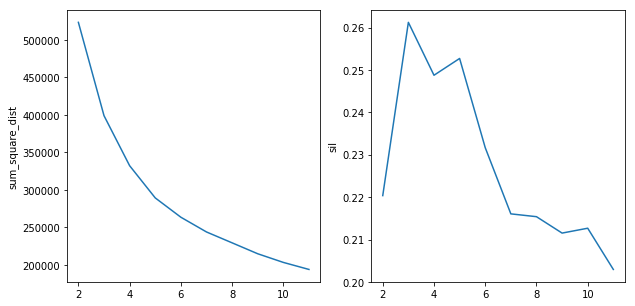

In [30]:
scale_hh = scale.fit_transform(data_hh)
model_hh = cluster_plot(scale_hh)

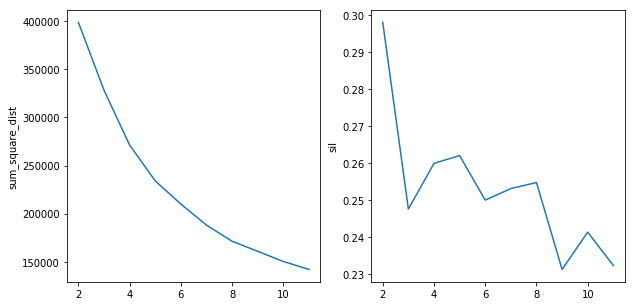

In [31]:
scale_hb = scale.fit_transform(data_hb)
model_hb = cluster_plot(data_hb)

选择适当K值分别进行聚类，并将相应标签连接至原始数据集

In [32]:
col_hh = pd.DataFrame(model_hh[3].labels_,columns=['hh_label'])
col_hb = pd.DataFrame(model_hb[2].labels_,columns=['hb_label'])
cluster = travel.join(col_hh).join(col_hb)
cluster.head()

,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,HH_has_children,HH_adults_num,interest,hh_label,hb_label
0,64,124035,73,932,3,312,420,149,96,626,0,2.0,0.2,1,1
1,69,138574,73,1000,7,241,711,263,68,658,0,5.0,0.4,2,1
2,57,148136,77,688,1,367,240,240,56,354,0,2.0,0.2,1,1
3,80,162532,74,932,7,291,832,197,86,462,1,2.0,1.0,1,1
4,48,133580,77,987,10,137,121,209,42,423,1,3.0,0.8,1,0


对各个簇的特征进行描述——使用原始数据

In [33]:
analysis = pd.pivot_table(cluster,index='hh_label',columns='hb_label',aggfunc='mean').T
analysis.swaplevel('hb_label',0).sortlevel(0)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  


hh_label                               0              1              2
hb_label                                                              
0        HH_adults_num          3.320966       2.046711       2.454411
         HH_dieting           159.351479     168.825031     149.727943
         HH_grandparent       280.750693     365.448911     413.319563
         HH_has_children        0.455810       0.243577       0.149012
         HH_head_age           55.115465      57.930433      69.098849
         age                   56.562876      54.952146      66.515049
         auto_member          453.418632     363.635349     443.417822
         home_value        231155.173756  152546.183785  170325.659192
         interest               0.405340       0.327098       0.343582
         interested_sport     217.337725     201.871824     226.835202
         loan_ratio            65.372823      72.074995      68.727206
         marital                8.787833       5.320491       6.029950
         risk_score           813.032401     733.327082     999.948805
1        HH_adults_num          3.321269       2.147778       2.739952
         HH_dieting           233.033293     263.902314     231.094250
         HH_grandparent       328.756154     504.956742     503.007257
         HH_has_children        0.367121       0.175461       0.164124
         HH_head_age           57.786220      62.859750      67.440547
         age                   60.342222      62.994901      70.046520
         auto_member          594.834602     524.459014     595.245162
         home_value        281129.284204  170214.462240  212057.124023
         interest               0.646284       0.652159       0.649963
         interested_sport     307.549722     302.452735     323.355136
         loan_ratio            60.048992      70.461685      63.388723
         marital                8.554933       5.420266       6.749070
         risk_score           847.490396     803.260762     999.927707

对各个簇的特征进行描述——使用原始数据

In [35]:
from sklearn.tree import DecisionTreeClassifier

dtc_hh = DecisionTreeClassifier()
dtc_hb = DecisionTreeClassifier()

dtc_hh.fit(cluster[household],cluster.hh_label)
dtc_hb.fit(cluster[hobby],cluster.hb_label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [37]:
import pydotplus
from IPython.display import Image
import sklearn.tree as tree

dot_hh = tree.export_graphviz(dtc_hh,
                              max_depth=2,
                              feature_names=household,
                              class_names=['0','1','2'],
                              filled=True,)
grap_hh = pydotplus.graph_from_dot_data(dot_hh)
Image(grap_hh.create_png())

warning, language png not recognized, use one of:
 dot canon plain plain-ext



有多个属性可用于分析用户的特征，使用决策树会计算属性对于类别的重要性，因此可用于发现其中较突出的属性（特征）

标签hh=0用户的突出特征是已婚低风险
标签hh=1用户的突出特征是未婚低风险
标签hh=2的用户的突出特征是高风险

In [40]:
dot_hb = tree.export_graphviz(
    dtc_hb,
    out_file=None, 
    feature_names=hobby, 
    class_names=['0','1'],
    max_depth=2, 
    filled=True
) 

graph_hb = pydotplus.graph_from_dot_data(dot_hb)  
Image(graph_hb.create_png()) 


warning, language png not recognized, use one of:
 dot canon plain plain-ext

